In [1]:
import torch
from torch import nn
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchsummary
from sklearn.manifold import TSNE

In [2]:
BASE_PATH = '.'
in_colab = False
need_train = False
load_features = True

In [3]:
import numpy as np

def to_X_y(ds):
    X = ds.iloc[:,1:].values.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y = ds.iloc[:,0].values
    
    return X, y

def to_groups(X, y):
    groups = [X[np.where(y==i)[0]] for i in np.unique(y)]
    
    return groups

def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]

        if match_group:
            b_group_idx = group_idx
            out_score += [1.0]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0.0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0).astype('float32').reshape(-1, 1)

In [4]:
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = '/content/drive/My Drive'

train_ds = pd.read_csv(f'{BASE_PATH}/data/fashion-mnist_train.csv')

train_groups = to_groups(*to_X_y(train_ds))

In [5]:
feature_model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
feature_model = feature_model.eval()
feature_model = feature_model.requires_grad_(False)

Using cache found in /home/viktor/.cache/torch/hub/pytorch_vision_v0.10.0
/home/viktor/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/viktor/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(244),
    transforms.ToTensor(),
    transforms.Lambda(lambda img: img.expand(3,*img.shape[1:])),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
class SiameseModel(nn.Module):
    def __init__(self, feature_model):
        super().__init__()
        self.feature_model = feature_model
        self.lin1 = nn.Linear(2000, 200)
        self.norm1 = nn.BatchNorm1d(200)
        self.act = nn.ReLU()
        self.lin2 = nn.Linear(200, 20)
        self.lin3 = nn.Linear(20, 1)
        self.sigm = nn.Sigmoid()
        
    def forward(self, x):
        x1 = x[0]
        x2 = x[1]
        x1_feat = self.feature_model(x1)
        x2_feat = self.feature_model(x2)
        result = torch.concat((x1_feat, x2_feat), dim=1)
        result = self.lin1(result)
        result = self.norm1(result)
        result = self.act(result)
        result = self.lin2(result)
        result = self.lin3(result)
        
        return self.sigm(result)

In [8]:
model = SiameseModel(feature_model)
if torch.cuda.is_available():
    model = model.to('cuda')

In [9]:
if not need_train:
    model.load_state_dict(torch.load(f'{BASE_PATH}/data/model_params.pt', map_location='cpu'))
else:
    batch_num = 500
    batch_halfsize = 256

    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = nn.MSELoss()

    for epoch in range(3):
        epoch_loss = 0
        i = 1
        for im1, im2, l in map(lambda x: gen_random_batch(train_groups, batch_halfsize), range(batch_num)):
            if i%20 == 0:
                print(f'doing {i}-th iteration, avg loss is {epoch_loss/i}')

            x1 = torch.stack([preprocess(x) for x in im1])
            x2 = torch.stack([preprocess(x) for x in im2])
            y = torch.tensor(l)

            if torch.cuda.is_available():
                x1 = x1.to('cuda')
                x2 = x2.to('cuda')
                y = y.to('cuda')

            out = model((x1, x2))
            l = loss(out, y)
            epoch_loss += l.item()
            l.backward()
            optim.step()

            i += 1
        print(f'epoch {epoch+1} loss: {epoch_loss}')
        torch.save(model.state_dict(), '/content/drive/My Drive/data/model_params.pt')

In [10]:
im1, im2, l = gen_random_batch(train_groups)
x1 = torch.stack([preprocess(x) for x in im1])
x2 = torch.stack([preprocess(x) for x in im2])
y = torch.tensor(l)

if torch.cuda.is_available():
    x1 = x1.to('cuda')
    x2 = x2.to('cuda')
    y = y.to('cuda')

out = model((x1, x2))
nn.functional.mse_loss(out, y)

tensor(0.2474, grad_fn=<MseLossBackward0>)

In [11]:
test_ds = pd.read_csv(f'{BASE_PATH}/data/fashion-mnist_test.csv')
X_test, y_test = to_X_y(test_ds)
test_groups = to_groups(X_test, y_test)

In [60]:
with torch.no_grad():
    im1, im2, l = gen_random_batch(test_groups)
    x1 = torch.stack([preprocess(x) for x in im1])
    x2 = torch.stack([preprocess(x) for x in im2])
    y = torch.tensor(l)

    if torch.cuda.is_available():
        x1 = x1.to('cuda')
        x2 = x2.to('cuda')
        y = y.to('cuda')

    out = model((x1, x2))

    print(torch.concat((out, y), dim=1))

tensor([[0.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [1.0327e-19, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00]])


In [36]:
test_features = torch.tensor([])
if load_features:
    test_features = torch.load(f'{BASE_PATH}/data/test_features.pt')
else:
    feature_model.eval()
    test_features = torch.tensor([])
    with torch.no_grad():
        i = 1
        for im in map(lambda x: preprocess(x), X_test):
            test_features = torch.stack((*test_features, feature_model(torch.unsqueeze(im, dim=0)).reshape(1000)))
            if i%500 == 0:
                print(f'done with {i}')
            i += 1
    torch.save(test_features, f'{BASE_PATH}/data/test_features.pt')

done with 500
done with 1000
done with 1500
done with 2000
done with 2500
done with 3000
done with 3500
done with 4000
done with 4500
done with 5000
done with 5500
done with 6000
done with 6500
done with 7000
done with 7500
done with 8000
done with 8500
done with 9000
done with 9500
done with 10000


In [63]:
tsne = TSNE(n_components=2,
            init='pca',
            method='barnes_hut',
            n_iter=500,
            verbose=2)
fitted_features = tsne.fit_transform(test_features.numpy())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.008s...
[t-SNE] Computed neighbors for 10000 samples in 2.413s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.535580
[t-SNE] Computed conditional probabilities in 1.063s
[t-SNE] Iteration 50: error = 88.2104416, gradient norm = 0.0124960 (50 iterations in 1.797s)
[t-SNE] It

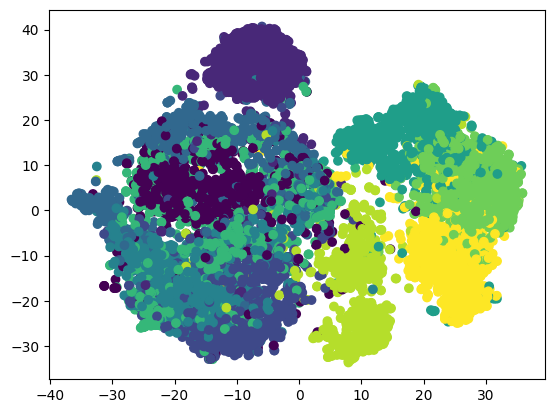

In [64]:
plt.scatter(fitted_features[:,0], fitted_features[:,1], c=y_test)
plt.show()

In [72]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(y_test))))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    print(f'plotting class {c_group}')
    plt.scatter(fitted_features[np.where(y_test == c_group), 0], fitted_features[np.where(y_test == c_group), 1],
                marker='o',
                color=c_color,
                linewidth='1',
                alpha=0.8,
                label=c_label)
# plt.legend()
plt.show()

plotting class 0
plotting class 1
plotting class 2
plotting class 3
plotting class 4
plotting class 5
plotting class 6
plotting class 7
plotting class 8
plotting class 9


TypeError: must be real number, not str

<Figure size 640x480 with 1 Axes>

In [73]:
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])